In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


# 3D dataset

In [4]:
BATCH_SIZE = 64
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download)
test_dataset = DataClass(split='test',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: C:\Users\cleve\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\cleve\.medmnist\organmnist3d.npz


In [5]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [6]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 28, 28, 28]) torch.Size([64, 1])


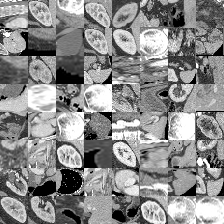

In [7]:
frames = train_dataset.montage(length=8, replace=True, save_folder="tmp/")
frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif)

# Models

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.bn1 = nn.GroupNorm(num_groups=2, num_channels=planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # self.bn2 = nn.GroupNorm(num_groups=2, num_channels=planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
                # nn.GroupNorm(num_groups=2, num_channels=self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.bn1 = nn.GroupNorm(num_groups=2, num_channels=planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # self.bn2 = nn.GroupNorm(num_groups=2, num_channels=planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        # self.bn3 = nn.GroupNorm(num_groups=2, num_channels=self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
                # nn.GroupNorm(num_groups=2, num_channels=self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # self.bn1 = nn.GroupNorm(num_groups=2, num_channels=64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = F.avg_pool2d(out, 4)
        # out = F.adaptive_avg_pool3d(out, output_size=4)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)


def ResNet50(in_channels, num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], in_channels=in_channels, num_classes=num_classes)

In [9]:
!pip install ACSConv

In [10]:
# from torchvision.models import resnet18
from acsconv.converters import ACSConverter
# model_2d is a standard pytorch 2D model
n_channels = 1
n_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
labels = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]
enc.fit(labels)

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


OneHotEncoder()

In [11]:
torch.cuda.empty_cache()

In [12]:
!nvidia-smi

Mon Apr  8 21:09:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX230         WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   59C    P3              N/A / ERR! |      0MiB /  2048MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### ResNet18

In [13]:
model_2d = ResNet18(in_channels=n_channels, num_classes=n_classes)
model_3d = ACSConverter(model_2d).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3d.parameters(), lr=0.001)
epoch_loss = []
accuracy = []
match = []
datasize = []

for epoch in range(25):
    print(f'Running Epoch: {epoch}... ')
    total_loss = []

    # Initialize variables for accuracy, match, and datasize
    correct_predictions = 0
    total_samples = 0

    for input_3d, label in train_loader:
        input_3d = input_3d.to(device).to(torch.float32)
        label_tensor = torch.squeeze(label, 1).long().to(device)
        output_3d = model_3d(input_3d)

        optimizer.zero_grad()
        loss = criterion(output_3d, label_tensor)
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # Calculate accuracy, match, and datasize for the current batch
        _, predicted = torch.max(output_3d, 1)
        correct_predictions += (predicted == label_tensor).sum().item()
        total_samples += label_tensor.size(0)

    # Append accuracy, match, and datasize for the current epoch
    accuracy.append(correct_predictions / total_samples)
    match.append(correct_predictions)
    datasize.append(total_samples)

    # Calculate and append average loss for the current epoch
    epoch_loss.append(sum(total_loss) / len(total_loss))

# Print or use accuracy, match, datasize, and epoch_loss as needed
print("\nAccuracy:", accuracy)
print("Match:", match)
print("Datasize:", datasize)
print("Epoch Loss:", epoch_loss)


Running Epoch: 0... 


### Accuracy

In [ ]:
total_correct = sum(match)
total_datasize = sum(datasize)
overall_accuracy = (total_correct / total_datasize) * 100

print("Overall Accuracy: {:.2f}%".format(overall_accuracy))

Overall Accuracy: 92.63%


### ResNet50

In [ ]:
model_2d = ResNet50(in_channels=n_channels, num_classes=n_classes)
model_3d = ACSConverter(model_2d).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3d.parameters(), lr=0.001)
epoch_loss = []
accuracy = []
match = []
datasize = []

for epoch in range(25):
    print(f'Running Epoch: {epoch}... ')
    total_loss = []

    # Initialize variables for accuracy, match, and datasize
    correct_predictions = 0
    total_samples = 0

    for input_3d, label in train_loader:
        input_3d = input_3d.to(device).to(torch.float32)
        label_tensor = torch.squeeze(label, 1).long().to(device)
        output_3d = model_3d(input_3d)

        optimizer.zero_grad()
        loss = criterion(output_3d, label_tensor)
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # Calculate accuracy, match, and datasize for the current batch
        _, predicted = torch.max(output_3d, 1)
        correct_predictions += (predicted == label_tensor).sum().item()
        total_samples += label_tensor.size(0)

    # Append accuracy, match, and datasize for the current epoch
    accuracy.append(correct_predictions / total_samples)
    match.append(correct_predictions)
    datasize.append(total_samples)

    # Calculate and append average loss for the current epoch
    epoch_loss.append(sum(total_loss) / len(total_loss))

# Print or use accuracy, match, datasize, and epoch_loss as needed
print("\nAccuracy:", accuracy)
print("Match:", match)
print("Datasize:", datasize)
print("Epoch Loss:", epoch_loss)


Running Epoch: 0... 
Running Epoch: 1... 
Running Epoch: 2... 
Running Epoch: 3... 
Running Epoch: 4... 
Running Epoch: 5... 
Running Epoch: 6... 
Running Epoch: 7... 
Running Epoch: 8... 
Running Epoch: 9... 
Running Epoch: 10... 
Running Epoch: 11... 
Running Epoch: 12... 
Running Epoch: 13... 
Running Epoch: 14... 
Running Epoch: 15... 
Running Epoch: 16... 
Running Epoch: 17... 
Running Epoch: 18... 
Running Epoch: 19... 
Running Epoch: 20... 
Running Epoch: 21... 
Running Epoch: 22... 
Running Epoch: 23... 
Running Epoch: 24... 

Accuracy: [0.36728395061728397, 0.6697530864197531, 0.7829218106995884, 0.8446502057613169, 0.845679012345679, 0.8641975308641975, 0.9084362139917695, 0.9197530864197531, 0.9382716049382716, 0.9331275720164609, 0.9372427983539094, 0.9403292181069959, 0.9444444444444444, 0.9331275720164609, 0.9475308641975309, 0.9722222222222222, 0.9783950617283951, 0.9783950617283951, 0.9866255144032922, 0.9691358024691358, 0.9259259259259259, 0.9557613168724279, 0.947530

### Accuracy

In [ ]:
total_correct = sum(match)
total_datasize = sum(datasize)
overall_accuracy = (total_correct / total_datasize) * 100

print("Overall Accuracy: {:.2f}%".format(overall_accuracy))

Overall Accuracy: 89.58%
